## G-learning for wealth optimization

The purpose of this notebook is to demonstrate the use of G-learning with quadratic rewards for optimization of a defined contribution retirement plan.

In [210]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import time
from scipy.optimize import minimize
import torch
from torch.autograd import Variable
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [211]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [212]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [213]:
# Define the G-learning portfolio optimization class
class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 params,
                 beta,
                 benchmark_portf,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky assets
                 init_x_vals, # array of initial asset position values (num_risky_assets + 1)
                 use_for_WM = True): # use for wealth management tasks

                
        self.num_steps = num_steps
        self.num_assets = num_risky_assets + 1 
        
        self.lambd = torch.tensor(params[0], requires_grad=False, dtype=torch.float64)
        self.Omega_mat = params[1] * torch.eye(self.num_assets,dtype=torch.float64)
        self.eta = torch.tensor(params[2], requires_grad=False, dtype=torch.float64)
        self.rho = torch.tensor(params[3], requires_grad=False, dtype=torch.float64)
        self.beta = torch.tensor(beta, requires_grad=False, dtype=torch.float64)
        
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate
        
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets # self.num_assets
        
        self.Sigma_r_np = Sigma_r # array of shape num_stocks x num_stocks
        
        self.reg_mat = 1e-3*torch.eye(self.num_assets, dtype=torch.float64)
        
        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1) 
        self.exp_returns_np = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))
                                      
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde_np = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde_np[1:,1:] = self.Sigma_r_np
            
        # make Torch tensors  
        self.exp_returns = torch.tensor(self.exp_returns_np,requires_grad=False, dtype=torch.float64)
        self.Sigma_r = torch.tensor(Sigma_r,requires_grad=False, dtype=torch.float64)
        self.Sigma_r_tilde = torch.tensor(self.Sigma_r_tilde_np,requires_grad=False, dtype=torch.float64)
        
        self.benchmark_portf = torch.tensor(benchmark_portf, requires_grad=False, dtype=torch.float64)
        
        # asset holding values for all times. Initialize with initial values, 
        # values for the future times will be expected values 
        self.x_vals_np = np.zeros((self.num_steps, self.num_assets))
        self.x_vals_np[0,:] = init_x_vals 
        
        # Torch tensor
        self.x_vals = torch.tensor(self.x_vals_np)
                
        # allocate memory for coefficients of R-, F- and G-functions        
        self.F_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=True)
        self.F_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64,
                               requires_grad=True)
        self.F_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)
        
        self.Q_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.Q_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.Q_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)
        
        self.R_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.R_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.R_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)

        
        self.reset_prior_policy()
        
        # the list of adjustable model parameters:
        self.model_params = [self.lambd, self.beta, self.Omega_mat, self.eta]         
        
        # expected cash installment for all steps
        self.expected_c_t = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # realized values of the target portfolio
        self.realized_target_portf = np.zeros(self.num_steps,dtype=np.float64)
        
        # expected portfolio values for all times
        self.expected_portf_val = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # the first value is the sum of initial position values
        self.expected_portf_val[0] = self.x_vals[0,:].sum()

    def reset_prior_policy(self):
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = torch.zeros(self.num_steps,self.num_assets,requires_grad=False,
                                       dtype=torch.float64)
        self.v_bar_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior_inv = torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior_inv[t,:,:] = 10.0 * torch.eye(self.num_assets).clone() # np.linalg.inv(self.Sigma_prior[t,:,:])
    
    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function 
        """
        x_plus = x_vals + u_vals
        
        p_hat = self.rho.clone() * self.benchmark_portf[t] + (1-self.rho.clone())*self.eta.clone()*x_vals.sum()
        
        aux_1 = - self.lambd.clone() * p_hat**2         
        aux_2 = - u_vals.sum()   
        aux_3 = 2*self.lambd.clone() * p_hat * x_plus.dot(torch.ones(num_assets) + exp_rets)
        aux_4 = - self.lambd.clone() * x_plus.mm(Sigma_hat.mv(x_plus))
        aux_5 = - u_vals.mm(self.Omega_mat.clone().mv(u_vals))
        
        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5  
    
    def compute_reward_fun(self):
        """
        Compute coefficients R_xx, R_ux, etc. for all steps
        """
        for t in range(0, self.num_steps):
            
            one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
            benchmark_portf = self.benchmark_portf[t]
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            with torch.no_grad():
                self.R_xx[t,:,:] = (-self.lambd.clone()*(self.eta.clone()**2)*(self.rho.clone()**2)*one_one_T_mat
                                     + 2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                     - self.lambd.clone()*Sigma_hat)

                self.R_ux[t,:,:] = (2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                     - 2*self.lambd.clone()*Sigma_hat)

                self.R_uu[t,:,:] = - self.lambd.clone() * Sigma_hat - self.Omega_mat.clone()

                self.R_x[t,:] =  (-2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*(1-self.rho.clone())*benchmark_portf *
                                     torch.ones(self.num_assets,dtype=torch.float64)
                                     + 2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret)

                self.R_u[t,:] = (2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret
                                 - torch.ones(self.num_assets,dtype=torch.float64))

                self.R_0[t] = - self.lambd.clone()*((1-self.rho.clone())**2) * (benchmark_portf**2)
                
         
    def project_cash_injections(self):
        """
        Compute the expected values of future asset positions, and the expected cash injection for future steps,
        as well as realized values of the target portfolio
        """
           
        # this assumes that the policy is trained
        for t in range(1, self.num_steps):  # the initial value is fixed 
            # increment the previous x_t
            delta_x_t = self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].mv(self.x_vals[t-1,:])
            self.x_vals[t,:] = self.x_vals[t-1,:] + delta_x_t
            
            # grow using the expected return
            self.x_vals[t,:] = (torch.ones(self.num_assets)+ self.exp_returns[t,:])*self.x_vals[t,:]
            
            # compute c_t
            self.expected_c_t[t] = delta_x_t.sum().data # detach().numpy()
            
            # expected portfolio value for this step
            self.expected_portf_val[t] = self.x_vals[t,:].sum().data # .detach().numpy()
                                                                                      
    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """
        
        # the auxiliary quantity to perform matrix calculations
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[-1,:]
        
        # Compute the reward function for all steps (only the last step is needed for this functions, while 
        # values for other time steps will be used in other functions)
        self.compute_reward_fun()
        
        if self.use_for_WM:
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            Sigma_hat_inv = torch.inverse(Sigma_hat + self.reg_mat)
            
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat.clone()
            Sigma_tilde_inv = torch.inverse(Sigma_tilde + self.reg_mat)
            
            Sigma_hat_sigma_tilde = Sigma_hat.mm(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.mm(Sigma_hat)
            Sigma_tilde_sigma_hat = Sigma_tilde.mm(Sigma_hat)
            
            Sigma_hat_Sigma_tilde_inv = Sigma_hat.mm(Sigma_tilde_inv)
            Sigma_3_plus_omega = self.lambd*Sigma_tilde_inv.mm(Sigma_hat_Sigma_tilde_inv) + self.Omega_mat.clone()    
                             
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            
            Sigma_tilde_inv_t_R_ux = Sigma_tilde_inv.t().mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.t().mm(self.R_uu[-1,:,:].clone())
            Sigma_tilde_inv_t_R_u = Sigma_tilde_inv.t().mv(self.R_u[-1,:].clone())
            
            Sigma_tilde_inv_R_u = Sigma_tilde_inv.mv(self.R_u[-1,:].clone())
            Sigma_tilde_inv_R_ux = Sigma_tilde_inv.mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.mm(self.R_uu[-1,:,:].clone())
            
            # though the action at the last step is deterministic, we can feed 
            # parameters of the prior with these values                     
              
            self.u_bar_prior[-1,:]   = (1/(2 * self.lambd.clone()))* Sigma_tilde_inv.clone().mv(self.R_u[-1,:].clone())
            self.v_bar_prior[-1,:,:] = (1/(2 * self.lambd.clone()))* Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())    
                
            # First compute the coefficients of the reward function F at the last step:        
            # F_xx       
            with torch.no_grad():
                self.F_xx[-1,:,:] = (self.R_xx[-1,:,:].clone()
                                     + (1/(2*self.lambd.clone()))* self.R_ux[-1,:,:].clone().t().mm(Sigma_tilde_inv_t_R_ux)
                                     + (1/(4*self.lambd.clone()**2))* self.R_ux[-1,:,:].clone().t().mm(
                                          Sigma_tilde_inv_t_R_uu.clone().mm(Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())))
                                    )

                # F_x                    
                self.F_x[-1,:] = (self.R_x[-1,:].clone()
                                     + (1/(self.lambd.clone()))* self.R_ux[-1,:,:].clone().t().mv(Sigma_tilde_inv_t_R_u.clone())
                                     + (1/(2*self.lambd.clone()**2))* self.R_ux[-1,:,:].clone().t().mv(
                                          Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                                )

                # F_0   
                self.F_0[-1] = (self.R_0[-1].clone() 
                                +  (1/(2*self.lambd.clone()))* self.R_u[-1,:].clone().dot(Sigma_tilde_inv_R_u.clone())
                                + (1/(4*self.lambd.clone()**2))* self.R_u[-1,:].clone().dot(
                                    Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                               )

                # for the Q-function at the last step:
                self.Q_xx[-1,:,:] = self.R_xx[-1,:,:].clone()
                self.Q_ux[-1,:,:] = self.R_ux[-1,:,:].clone()
                self.Q_uu[-1,:,:] = self.R_uu[-1,:,:].clone()
                self.Q_u[-1,:] = self.R_u[-1,:].clone()
                self.Q_x[-1,:] = self.R_x[-1,:].clone()
                self.Q_0[-1] = self.R_0[-1].clone()

    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """   
        print('Doing G-learning, it may take a few seconds...')
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # make matrix Sigma_hat_t        
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
        Sigma_hat_t = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
        
        # matrix A_t = diag(1 + r_bar_t)
        A_t = torch.diag(torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:])
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].clone()  
            curr_v_bar_prior = self.v_bar_prior[t,:,:].clone()     
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = torch.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*torch.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
            tol = torch.max(err_u_bar, err_v_bar)  # tol = 0.5*(err_u_bar + err_v_bar)
            
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break
                
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
                
        ones = torch.ones(self.num_assets,dtype=torch.float64)    
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
        with torch.no_grad():
            self.Q_xx[t,:,:] = (self.R_xx[t,:,:].clone() 
                                + self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                               + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() ) )


            self.Q_ux[t,:,:] = (self.R_ux[t,:,:].clone() 
                                + 2 * self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                               + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() ) 
                               )

            self.Q_uu[t,:,:] = (self.R_uu[t,:,:].clone()  
                                + self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                               + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() )
                                - self.Omega_mat.clone()
                               )


            self.Q_x[t,:] = self.R_x[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone()) 
            self.Q_u[t,:] = self.R_u[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone())
            self.Q_0[t]   = self.R_0[t].clone() + self.gamma * self.F_0[t+1].clone()

    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = (self.beta.clone() * self.Q_ux[t,:,:].clone() 
               + self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone()))
        W_t = (self.beta.clone() * self.Q_u[t,:].clone() 
               +  self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:]).clone())
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()
        Sigma_p_bar_inv = torch.inverse(Sigma_p_bar + self.reg_mat)
        with torch.no_grad():
        # update parameters of F-function
            self.F_xx[t,:,:] = self.Q_xx[t,:,:].clone() + (1/(2*self.beta.clone()))*(U_t.t().mm(Sigma_p_bar_inv.clone().mm(U_t))
                                        - self.v_bar_prior[t,:,:].clone().t().mm(
                                            self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())))


            self.F_x[t,:] = self.Q_x[t,:].clone() + (1/self.beta.clone())*(U_t.mv(Sigma_p_bar_inv.clone().mv(W_t))
                                        - self.v_bar_prior[t,:,:].clone().mv(
                                            self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))


            self.F_0[t] = self.Q_0[t].clone() + ( (1/(2*self.beta.clone()))*(W_t.dot(Sigma_p_bar_inv.clone().mv(W_t))
                                        - self.u_bar_prior[t,:].clone().dot(
                                            self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))
                                        - (1/(2*self.beta.clone())) * (torch.log(torch.det(self.Sigma_prior[t,:,:].clone()+
                                                                                  self.reg_mat))
                                                           - torch.log(torch.det(Sigma_p_bar_inv.clone() + self.reg_mat))) )

    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()

        Sigma_prior_new = torch.inverse(new_Sigma_prior_inv + self.reg_mat)
        
        # update parameters using the previous value of Sigma_prior_inv
        self.u_bar_prior[t,:] = Sigma_prior_new.mv(self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())
                                              + self.beta.clone() * self.Q_u[t,:].clone())
        
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.clone().mm(self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())
                                              + self.beta.clone() * self.Q_ux[t,:,:].clone())
        
        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new.clone()
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv.clone()
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:].clone()
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:].clone()
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:].clone()
            
    def trajs_to_torch_tensors(self,trajs):
        """
        Convert data from a list of lists into Torch tensors
        """
        num_trajs = len(trajs)
        
        self.data_xvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
        self.data_uvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
            
        for n in range(num_trajs):
            for t in range(self.num_steps):
                self.data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64).clone()
                self.data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64).clone()
                
    def compute_reward_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.R_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.R_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.R_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.R_x[t,:].clone())
        aux_u = u_t.dot(self.R_u[t,:].clone())
        aux_0 = self.R_0[t].clone()
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_G_fun_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.Q_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.Q_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.Q_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.Q_x[t,:].clone())
        aux_u = u_t.dot(self.Q_u[t,:].clone())
        aux_0 = self.Q_0[t].clone()
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_F_fun_on_traj(self,
                              t,
                              x_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.F_xx[t,:,:].clone().mv(x_t))
        aux_x = x_t.dot(self.F_x[t,:].clone())
        aux_0 = self.F_0[t].clone()
        
        return aux_xx + aux_x + aux_0
                 
    def MaxEntIRL(self,
                  trajs,
                  learning_rate,
                  err_tol, max_iter):
        
        """
        Estimate parameters of the reward function using MaxEnt IRL.
        Inputs:
        
        trajs - a list of trajectories. Each trajectory is a list of state-action pairs, stored as a tuple.
                We assume each trajectory has the same length
        """
        
        # omega is a tunable parameter that determines the cost matrix self.Omega_mat
        omega_init = 15.0
        self.omega = torch.tensor(omega_init, requires_grad=True, dtype=torch.float64)
        
        beta_init = 50 # Beta is fixed and not a learned parameter.
        self.beta = torch.tensor(beta_init, requires_grad=True, dtype=torch.float64)
        
        reward_params =  [self.lambd, self.eta, self.rho, self.omega, self.beta]
        
        print("Omega mat...")
        self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
        print("g learning...")
        self.reset_prior_policy()
        self.G_learning(err_tol, max_iter)
        print("intialize optimizer...")
        optimizer = optim.Adam(reward_params, lr=learning_rate)
        print("zero grad...")
        optimizer.zero_grad()
        
        num_trajs = len(trajs)
        print("trajs_to_torch_tensors...")
        
        # fill in Torch tensors for the trajectory data
        self.trajs_to_torch_tensors(trajs)
        print("constructing zero tensors...")   
        self.realized_rewards = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64,requires_grad=True)
        self.realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")  
        self.realized_G_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64, requires_grad=True)
        self.realized_F_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")  
        self.realized_G_fun_cum = torch.zeros(num_trajs,dtype=torch.float64, requires_grad=True)
        self.realized_F_fun_cum = torch.zeros(num_trajs,dtype=torch.float64, requires_grad=True)
        print("done...")  
        
        num_iter_IRL = 3
        
        for i in range(num_iter_IRL):
            print('GIRL iteration = ', i)
    
            self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
    
            for n in range(101):
                if n%100==0:
                    print(n)
                for t in range(self.num_steps):
                    
                    # compute rewards obtained at each step for each trajectory
                    # given the model parameters
                    self.realized_rewards[n,t] = self.compute_reward_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                                                                
            
                    # compute the log-likelihood by looping over trajectories
                    self.realized_G_fun[n,t] = self.compute_G_fun_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                
                
                    self.realized_F_fun[n,t] = self.compute_F_fun_on_traj(t,
                                                                self.data_xvals[n,t,:])
                

                self.realized_cum_rewards[n] = self.realized_rewards[n,:].sum().clone()
                self.realized_G_fun_cum[n] = self.realized_G_fun[n,:].sum().clone()
                self.realized_F_fun_cum[n] = self.realized_F_fun[n,:].sum().clone()
            
            # the negative log-likelihood will not include terms ~ Sigma_p as we do not optimize over its value
            loss = - self.beta.clone()*(self.realized_G_fun_cum.sum().clone() - self.realized_F_fun_cum.sum().clone())
        
            optimizer.zero_grad()
        
            loss.backward() 
        
            optimizer.step()
        
            print('Iteration = ', i)
            print('Loss = ', loss.detach().numpy())
        
           
        print('Done optimizing reward parameters')          

## Simulate portfolio data

### Simulate the market factor under a lognormal distribution with a fixed drift and vol

In [214]:
mu_market = 0.025
vol_market = 0.1
init_market_val = 100.0

r_rf = 0.02  # risk-free rate - the first asset will be cash

num_steps = 20 # number of steps for planning horizon
dt = 0.25 # quarterly time steps

num_risky_assets = 99 # 100

returns_market = np.zeros(num_steps)
market_vals = np.zeros(num_steps)
market_vals[0] = 100.0  # initial value


        
for t in range(1,num_steps):

        rand_norm = np.random.randn()
        
        # use log-returns of market as 'returns_market'
        returns_market[t] = mu_market * dt + vol_market * np.sqrt(dt) * rand_norm
        
        market_vals[t] = market_vals[t-1] * np.exp((mu_market - 0.5*vol_market**2)*dt + 
                                                         vol_market*np.sqrt(dt)*rand_norm)
        

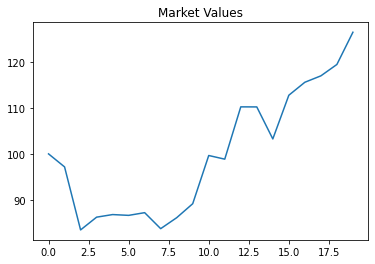

In [217]:
plt.plot(market_vals)
plt.title('Market Values');

### Simulate market betas and idiosyncratic alphas within pre-defined ranges

In [231]:
beta_min = -0.2
beta_max = 0.6
beta_vals = np.random.uniform(low=beta_min, high=beta_max, size=num_risky_assets)

alpha_min = - 0.1
alpha_max = 0.1
alpha_vals = np.random.uniform(low=alpha_min, high=alpha_max, size=num_risky_assets)

print(beta_vals[0:10])
print(alpha_vals[0:10])

[ 0.14856468  0.24924939  0.54944275  0.5205584  -0.16729943  0.0448035
 -0.04732457  0.20966338  0.2437854   0.27064863]
[-0.05481465 -0.05275637  0.06045568  0.01311449  0.05836784  0.04123632
  0.02314436  0.0150102   0.06372634 -0.03340037]


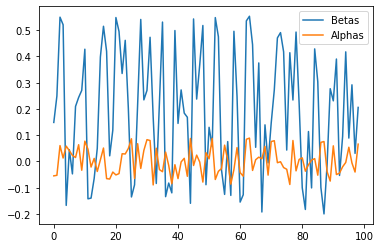

In [232]:
plt.plot(beta_vals,label='Betas')
plt.plot(alpha_vals,label='Alphas')
plt.legend();

### Simulate time-dependent expected returns

In [233]:
# Time-independent expected returns would be equal to alpha + beta * expected_market_return 
# Make them time-dependent (and correlated with actual returns) as alpha + beta * oracle_market_returns

oracle_coeff = 0.2
mu_vec = mu_market * np.ones(num_steps)
oracle_market_returns = mu_vec * dt + oracle_coeff*(returns_market - mu_vec)

expected_risky_returns = np.zeros((num_steps, num_risky_assets))

for t in range(num_steps):
    expected_risky_returns[t,:] = alpha_vals * dt + beta_vals * oracle_market_returns[t]

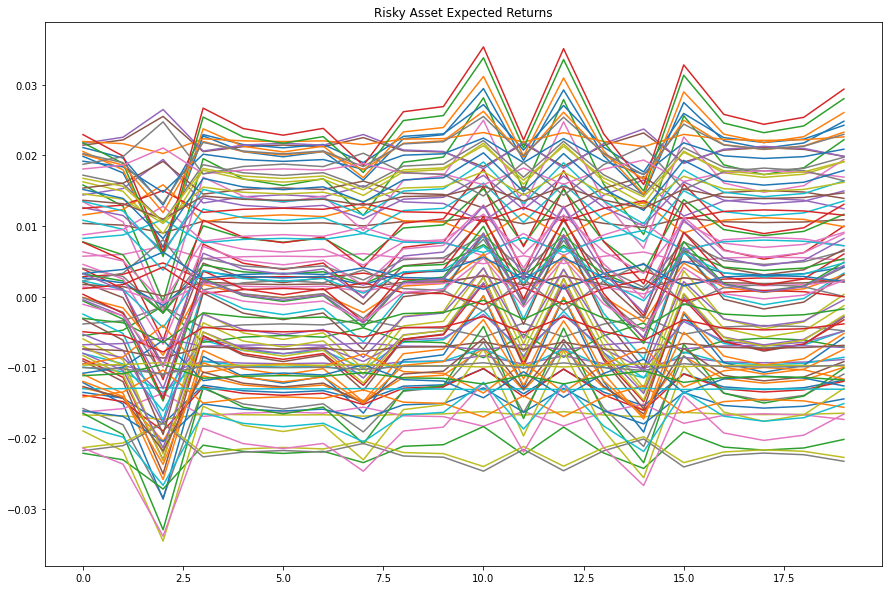

In [235]:
plt.figure(figsize=(15,10))
plt.plot(expected_risky_returns);
plt.title('Risky Asset Expected Returns');

### Initial values of all assets 

In [236]:
val_min = 20.0
val_max = 120.0

init_risky_asset_vals = np.random.uniform(low=val_min, high=val_max, size=num_risky_assets)

### Simulate realized returns and asset prices

In [237]:
# Generate realized returns and realized asset values by simulating from a one-factor model 
# with time-dependent expected returns

risky_asset_returns = np.zeros((num_steps, num_risky_assets))
risky_asset_vals = np.zeros((num_steps, num_risky_assets))

idiosync_vol =  0.05 # vol_market  

for t in range(num_steps):
    
    rand_norm = np.random.randn(num_risky_assets)
        
    # asset returns are simulated from a one-factor model
    risky_asset_returns[t,:] = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
    # asset values
    if t == 0:
        risky_asset_vals[t,:] = init_risky_asset_vals
    else:
        risky_asset_vals[t] = risky_asset_vals[t-1] * (1 + risky_asset_returns[t,:])
   

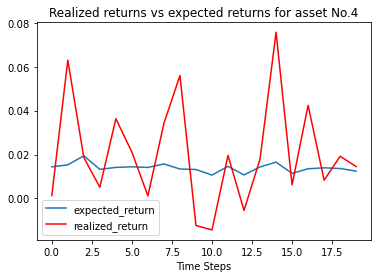

In [239]:
# Compare the realized and expected returns
# Note that they should appear correlated.

# pick a random asset ID to show
asset_idx =  4 

plt.plot(expected_risky_returns[:,asset_idx],label='expected_return')
plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized returns vs expected returns for asset No.'+ str(asset_idx))
plt.show()

### Compute the empirical correlation matrix using realized returns

In [240]:
cov_mat_r = np.cov(risky_asset_returns.T) 

print(cov_mat_r.shape)

D, v = np.linalg.eigh(cov_mat_r)

eigenvals = D[::-1]  # put them in a descended order

(99, 99)


In [241]:
# eigenvalues: the largest eigenvalue is the market factor 
eigenvals[0:10]

array([0.04908893, 0.00529003, 0.00452712, 0.00432243, 0.00385918,
       0.00377825, 0.0032207 , 0.00306545, 0.00281809, 0.00273012])

In [242]:
cov_mat_torch = torch.tensor(cov_mat_r)

torch.pinverse(cov_mat_torch)

tensor([[ 48.3717,  17.9693,   4.1298,  ...,   0.4932, -14.2783,  -0.4995],
        [ 17.9693,  73.5410,  -6.1382,  ..., -26.2293, -12.4369,  25.7852],
        [  4.1298,  -6.1382,  50.7910,  ..., -10.6274,  15.3185,  -2.2983],
        ...,
        [  0.4932, -26.2293, -10.6274,  ...,  56.9110,   4.1127,   2.9919],
        [-14.2783, -12.4369,  15.3185,  ...,   4.1127,  75.4968,   7.7721],
        [ -0.4995,  25.7852,  -2.2983,  ...,   2.9919,   7.7721,  99.3973]],
       dtype=torch.float64)

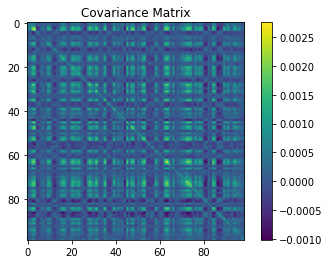

In [245]:
plt.imshow(cov_mat_r)
plt.colorbar();
plt.title('Covariance Matrix');

### Add a riskless bond as one more asset

In [247]:
num_assets = num_risky_assets + 1

bond_val = 100.0

# add the bond to initial assets
init_asset_vals = np.hstack((np.array([bond_val]),
                            init_risky_asset_vals))

### Make the initial portfolio 

In [248]:
# consider here two choices: equal or equally-weighted 
init_port_choice =  'equal' 

init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)

x_vals_init = np.zeros(num_assets)

if init_port_choice == 'equal': 
    # hold equal amounts of cash in each asset
    amount_per_asset = init_cash/num_assets
    x_vals_init = amount_per_asset * np.ones(num_assets)

elif init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals_init = amount_per_asset * init_asset_vals
    

### Make the target portfolio

In [249]:
# Generate a target portfolio term structure by defining it as 
# the initial portfolio growing at some fixed and high rate
target_portfolio = [init_cash]

target_return = 0.15 
coeff_target = 1.1 

for i in range(1,num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = coeff_target*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

1100.0 2242.9908581478385


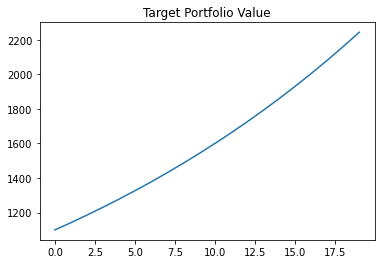

In [251]:
plt.plot(target_portfolio)
plt.title('Target Portfolio Value');

### Define model parameters

In [252]:
riskfree_rate = 0.02
fee_bond = 0.05 # 0.01 # 
fee_stock = 0.05 # 0.05 # 20.0 # 0.1 # 1.0 # 100 # 1.0 # 0.5 

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)

# model parameters
lambd = 0.001 
Omega_mat = 15.5 * np.diag(all_fees) 
eta = 1.5 

beta = 100.0
gamma = 0.95 

exp_returns = expected_risky_returns

Sigma_r = cov_mat_r

# Generate the benchmark target portfolio by growing the initial portfolio value at rate eta
target_return =  0.5
benchmark_portf = [ init_cash   * np.exp(dt * target_return)]

rho = 0.4 

for i in range(1,num_steps):
    benchmark_portf.append(benchmark_portf[i-1]*np.exp(dt * target_return) )
    
print(benchmark_portf[0], benchmark_portf[-1])

1133.1484530668263 12182.493960703472


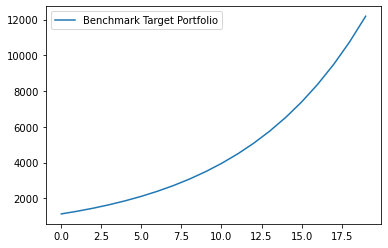

In [254]:
plt.plot(benchmark_portf,label='Benchmark Target Portfolio');
plt.legend();

### Simulate portfolio data

Produce a list of trajectories, where each trajectory is a list made of state-action pairs

In [255]:
lambd = 0.001 
omega = 1.0 
beta = 1000.0
eta = 1.5 # 1.3 # 1.5 # 1.2
rho = 0.4

In [256]:
reward_params=[lambd, omega, eta, rho]

In [257]:
# Create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 reward_params,  
                 beta,                
                 benchmark_portf,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 expected_risky_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals_init, # array of initial values of len (num_stocks+1)
                 use_for_WM = True) # use for wealth management tasks

In [258]:
G_learner.reset_prior_policy()
error_tol=1.e-8 
max_iter_RL = 200
G_learner.G_learning(error_tol, max_iter_RL)

Doing G-learning, it may take a few seconds...


In [259]:
num_sim = 1000
trajs = []
np.random.seed(0)
torch.manual_seed(0)
t_0 = time.time()
realized_returns = np.zeros((num_steps,num_risky_assets))

x_vals = [x_vals_init]
returns_all = []
for n in range(num_sim):
    this_traj = []
    x_t = x_vals_init[:]
    returns_array = []
    for t in range(0,num_steps):
        mu_t = G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:].mv(torch.tensor(x_t))
        u_t = np.random.multivariate_normal(mu_t.detach().numpy(), G_learner.Sigma_prior[t,:].detach().numpy())
        # compute new values of x_t

        x_next = x_t +u_t
        # grow this with random return
        
        idiosync_vol =  0.05 # vol_market     
        rand_norm = np.random.randn(num_risky_assets)
        
        # asset returns are simulated from a one-factor model
        risky_asset_returns_ = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        realized_returns[t,:] += risky_asset_returns_/num_sim
        returns = np.hstack((riskfree_rate*dt, risky_asset_returns_))
        
        x_next = (1+returns)*x_next
        port_returns=(x_next.sum() -x_t.sum() -np.sum(u_t) - 0.015*np.abs(u_t).sum())/x_t.sum()
        
        this_traj.append((x_t, u_t))
        
        # rename
        x_t = x_next
        returns_array.append(port_returns) 
    # end the loop over time steps
    trajs.append(this_traj)
    returns_all.append(returns_array)

print('Done simulating trajectories in %f sec'% (time.time() - t_0))        

Done simulating trajectories in 56.222038 sec


### Calculate performance of G-learner (Diagnostics only)

In [260]:
returns_all_G = returns_all

In [261]:
SR_G = 0
for i in range(num_sim):
    SR_G += (np.mean(returns_all_G[i])-riskfree_rate*dt)/np.std(returns_all_G[i])

SR_G/=num_sim
print(SR_G)

-0.0368415972878614


In [262]:
SR_EW = (np.mean(realized_returns)-riskfree_rate*dt)/np.std(realized_returns)

In [263]:
SR_EW

-0.09935937195143313

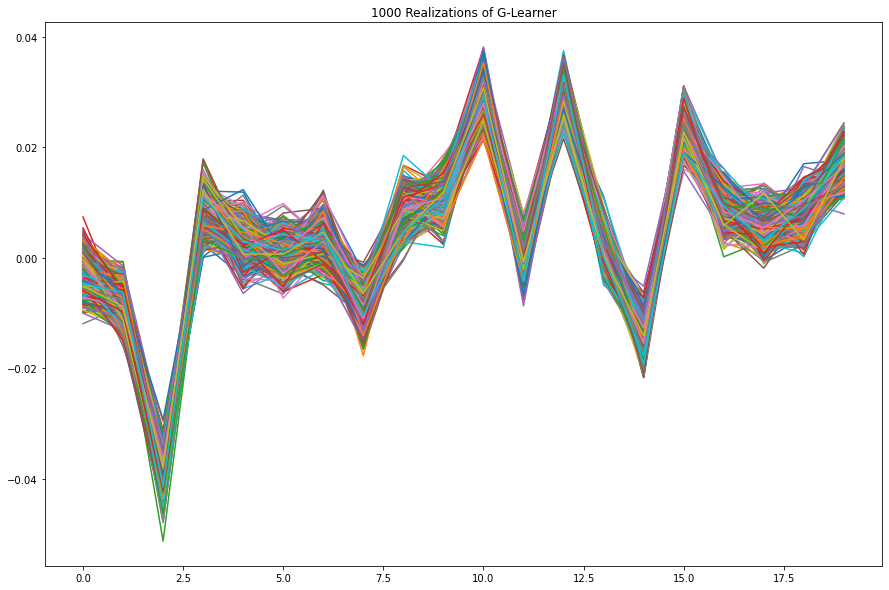

In [267]:
plt.figure(figsize=(15,10))
for i in range(1000):
    plt.plot(returns_all_G[i])
plt.title('1000 Realizations of G-Learner');

In [268]:
r_G = np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
    for i in range(num_sim):
        r_G[n]+=returns_all_G[i][n]
    r_G[n]/=num_sim


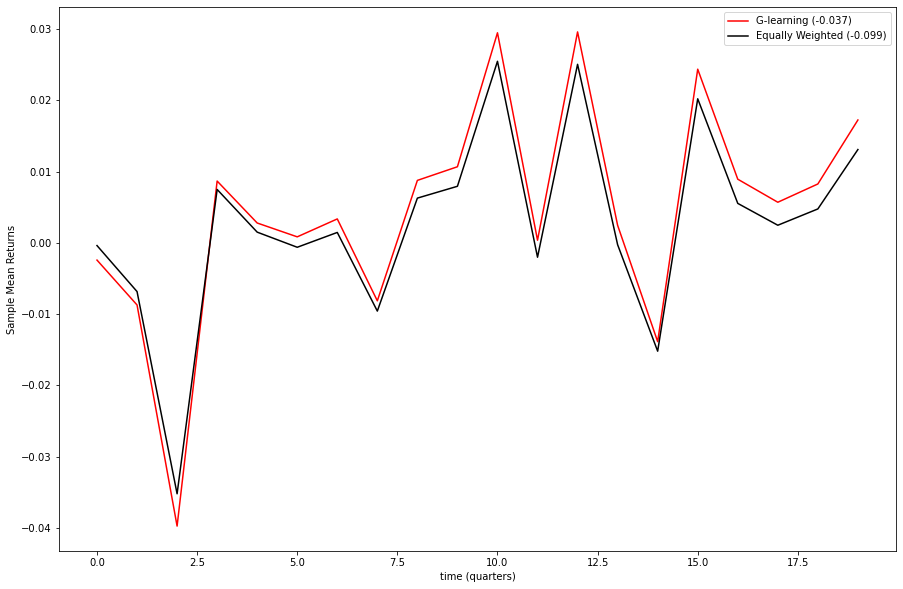

In [269]:
plt.figure(figsize=(15,10))
plt.plot(r_G, label='G-learning (' + str(np.round(SR_G,3)) + ')', color='red')
plt.plot(np.mean(realized_returns,axis=1),label='Equally Weighted (' + str(np.round(SR_EW,3)) + ')',color='k')
plt.xlabel('time (quarters)')
plt.ylabel('Sample Mean Returns')
plt.legend();

In [156]:
np.save('State_act_trajs.npy', trajs)

In [157]:
#trajs = np.load('State_act_trajs.npy')

## Plot rewards and cash installments

We can plot the learng rewards and observe the required cash installements from the G-learner model 

In [270]:
reward_params=[lambd, omega, eta, rho]
G_learner = G_learning_portfolio_opt(num_steps,
                                      reward_params,
                                      beta,
                                      benchmark_portf,
                                      gamma,
                                      num_risky_assets,
                                      riskfree_rate,
                                      expected_risky_returns,
                                      Sigma_r,
                                      x_vals_init,
                                      use_for_WM=True)

In [271]:
err_tol = 1.e-10 
max_iter = 500

t_0 = time.time()
G_learner.reset_prior_policy()
G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)
num_trajs = len(trajs)

data_xvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
data_uvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
num_trajs = len(trajs)       
for n in range(num_trajs):
        for t in range(num_steps):
            data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64)
            data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64)

realized_rewards = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)

realized_G_fun = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
realized_F_fun  = torch.zeros(num_trajs,  num_steps, dtype=torch.float64, requires_grad=False)

realized_G_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)  
realized_F_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)         

# compute the rewards and realized values of G- and F-functions from 
# all trajectories
for n in range(num_trajs):
    for t in range(num_steps):
                
                realized_rewards[n,t] = G_learner.compute_reward_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])

                realized_G_fun[n,t] = G_learner.compute_G_fun_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])

                realized_F_fun[n,t] = G_learner.compute_F_fun_on_traj(t,
                                data_xvals[n,t,:])
                 
    realized_cum_rewards[n] = realized_rewards[n,:].sum()
    realized_G_fun_cum[n] = realized_G_fun[n,:].sum()
    realized_F_fun_cum[n] = realized_F_fun[n,:].sum()

print('Done in %f sec'% (time.time() - t_0))


Doing G-learning, it may take a few seconds...
Done in 21.325267 sec


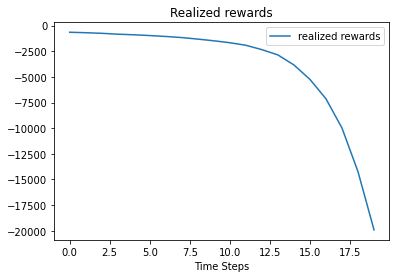

In [272]:
sim_idx =  999

realized_rewards = realized_rewards[sim_idx,:].detach().numpy()
plt.plot(realized_rewards,label='realized rewards')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized rewards');

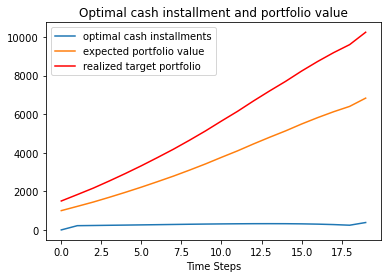

In [273]:
G_learner.project_cash_injections()

eta_ = G_learner.eta.detach().numpy()
realized_target_portf = eta_ * G_learner.expected_portf_val.numpy()

plt.plot(G_learner.expected_c_t, label='optimal cash installments')
plt.plot(G_learner.expected_portf_val, label='expected portfolio value')
plt.plot(realized_target_portf,label='realized target portfolio',color='r')

plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal cash installment and portfolio value');

In [276]:
print('Optimal Cash Installments:')
G_learner.expected_c_t

Optimal Cash Installments:


tensor([  0.0000, 219.8388, 229.2854, 240.0876, 250.0800, 260.7409, 271.7027,
        282.7592, 293.7007, 303.3817, 311.5933, 318.0853, 322.6522, 323.7854,
        322.0382, 314.4951, 299.6425, 276.8716, 243.6518, 383.2522],
       dtype=torch.float64)

Show the histogram of cumulative rewards

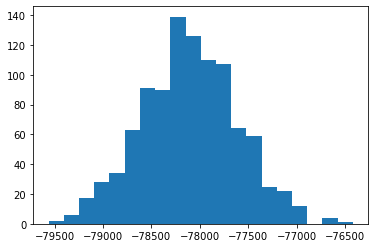

In [277]:
plt.hist(realized_cum_rewards.detach().numpy(), bins=20);